---
title: Logistic Regression
author: Alec Kyritsis
date: '2024-04-14'
image: "media/descent.jpg"
description: "Implementing Logistic Regression with Momentum in PyTorch."
format: html
---

In [1]:
#Packages and Style
%load_ext autoreload
%autoreload 2
import torch
import pandas as pd
import math
import matplotlib.pyplot as plt
from logistic import LogisticRegression
from logistic import Utility
plt.rcParams['font.family'] = "Courier"



## Abstract

We explore the mathematics that inform regression models and implement Logistic Regression in PyTorch. We perform tests to assess the correctness, speed, and generializability of the model. The code may be found at https://github.com/a1kyritsis/a1kyritsis_blog.github.io/tree/main/posts/logisticRegression.

# Logistic Regression

Logistic Regression is a popular, intuitive form of a machine learning. At a high level, given some set of features, we hope to weight said features in such a way that we minimize the number of mispredictions. To do so, we transform this to a multivariate minimization problem, where we find the global minimum of a convex function. We provide a brief, semi-formal overview: 

Suppose we have some data matrix $\mathbb{X}$ with $n$ observations and set of features $F$. Also suppose we believe $P \subseteq F, \; |P| = p$ to be a set of features with some deal of predictive power. Let $X \subseteq \mathbb{X}$ be a $n \times p$ matrix formed by indexing columns of $\mathbb{X}$ with $P$. We distinguish between data matrix $\mathbb{X}$ and $X$ since we usually do not train on all features. Let $l$ denote an arbitrary loss function, $\vec{w}$ the set of feature weights, $\vec{x_i}$ the $i^{th}$ row of $X$, and $y_i \in \{0, 1\}$ the binary label of $x_i$. We then hope to solve for the optimal set of weights $\hat{w}$ such that

$$\hat{w} = \text{argmin}_{\vec{w}} \; \left[ \frac{1}{n} \sum_{i = 1}^n l(<\vec{w}, \vec{x_i}>, y_i) \right].$$

In other words, the set of weights $\hat{w}$ that minmizes loss across all observations. One problem is that our loss function may not have a global minimum which can be found. The dirty little trick of Logistic Regression is to choose a convex loss function when evaluating the per observation loss. This ensures that our global loss function is also convex. Since we are developing an algorithm for logistic regression, it makes sense that we choose the logistic loss function

$$l(s, y) = -y log\left[ \sigma(s) \right] - (1 - y)log\left[ 1 - \sigma(s) \right]$$

where $y$ is the binary label and $s$ the score with respect to the $i^{th}$ observation. Here, $\sigma(s)$ is just the sigmoid function

$$\sigma(s) = \frac{1}{1 + exp\left[ - s \right]}.$$

Now that we have established our loss function, we may turn to the notion of gradient descent. In Calc I, we learned that the derivative of a function is its rate of change. This idea can be extended to multivariant functions in $\mathbb{R}^p$. Rather than looking at the rate of change for a single variable, we look at the rate of change for each input $x_i, \; i \le p$, holding all else constant. For some input tuple $ T = (x_1, ..., x_p)$ and multivariant function $G: \mathbb{R}^p \longrightarrow \mathbb{R}^k, \; k \in \mathbb{Z}^+$, we may evualuate $T$ at the gradient $\nabla G(T)$ to find the rate of change in each dimension. 

![Multivariable Convex Function in $\mathbb{R}^3$](media/multi.jpg)

Even better, remember in Calc I when we needed to find the minimum or maximum of a function, we set the derivative equal to $0$ and solved for the critical point. We can complete an identical (albeit slightly harder) process with the gradient and a multivariant function. Since $L$ is a convex function, we can then find its minimum using the gradient $\nabla L$. We state the gradient of the Logistic Loss Function without proof: 

$$ \nabla L(\vec{w}) =  \frac{1}{n} \sum_{i = 1}^n (\sigma(<\vec{w}, \vec{x_i}>) - y_i)x_i.$$

If we find where $\nabla L(\vec{w}) = 0$, we find the set of weights $\vec{w}$ that minimizes loss and hence maximizes our chance of attaining a successful prediction. 

The final hurdle we must then navigate is how to actual do this. Since it's 2024, we could force the computer to do some algebra. However, this uses uncessary computational power and the algebra may not always be nice. One way to think of the gradient is as a vector tangent to a point on our function. We then use the gradient to "point" us in the direction of the minimum. 

![Gradient at Point of Function in $\mathbb{R}^3$](media/grad.jpg)

Since $L$ is convex ($\mathcal{H}(L) < 0$), its gradient is always negative, so we will always be descending. The process is then as follows: Pick some point on $L$, call it $w_1$. Evaluate $\nabla L (w_1)$, to find $w_2$. Repeat this process until some arbitrary stopping parameter is reached. Formally, at the $k^{th}$ iteration of our algorithm, we find $w_{k + 1}$ as follows:

$$ w_{k + 1} \longleftarrow w_k - \alpha \nabla L(w_k) + \beta (w_k - w_{k - 1}).$$

Here, $\alpha$ and $\beta$ are two learning rate parameters which control the step size of our descent. The first parameter $\alpha$ controls the impact of the gradient. The second parameter $\beta$ controls the momentum term.

## Implementation

We walk through some of the important code chunks in our Logistic Regression algorithm. First, we score by taking the row-wise dot product, equivalent to matrix multiplication. If no weight vector is given, we initialize it:

In [ ]:
 def score(self, X):
        if self.w is None:
            self.w = torch.rand((X.size()[1]))
        return torch.matmul(X, self.w)

Next, we define a prediction function. If the score of observation $s_i$ satisfies $s_i > 0$, then we have found a seperating hyperplane and correctly classified the data. We achieve this as follows: 

In [ ]:
def predict(self, X):
        score_vector = self.score(X)
        return (score_vector > 0).int()

We move to larger code blocks. We calculate the gradient using the mentioned formula

In [ ]:
def grad(self, X, y, s):
        #computes the gradient
        n = X.shape[0]
        return (1/n) * torch.sum((X * (self.sigmoid(s) - y).unsqueeze(1)), dim = 0)

We then implement a gradient descent optimizer, which performs the update $w_{k + 1} \longleftarrow w_k - \alpha \nabla L(w_k) + \beta (w_k - w_{k - 1})$:

In [ ]:
 def gradientDescentOptimizer(self, X, y, alpha, beta):
        #spicy gradient descent
        if self.w_prev == None:
            self.w_prev = torch.zeros(X.shape[1]) # w_{k - 1}
        
        if self.w_next == None:
            self.w_next = torch.zeros(X.shape[1]) #w_{k + 1}
        
        s = self.score(X) #initialize score for w
        self.w_next = self.w - alpha * self.grad(X, y, s) + beta * (self.w - self.w_prev) #update
        self.w_prev = self.w #reassign
        self.w = self.w_next

Here, $\texttt{self.W} = w_k$, $\texttt{w\_prev} = w_{k - 1}$, and $\texttt{w\_prev} = w_{k + 1}$. Finall for convenience, we also implement a training method that performs the looping functionality; or, the descent itself. The method records the number of iterations to converge and loss at each iteration. 

In [ ]:
def train_logistic(X, y, alpha, beta, epsilon, LR):
        
        L = LR.loss(X, y)
        loss = []
        step = 0

        while(torch.norm(LR.grad(X, y, LR.score(X))) > epsilon):
            LR.gradientDescentOptimizer(X, y, alpha, beta)
            L = LR.loss(X, y)
            loss.append(L)
            step += 1

        return [step, loss]

The condition in the $\texttt{while}$ loop is the stopping condition. Recall that our loss is minimized when $\nabla L = 0$. In practice, this can be difficult to achieve, so we cheat by letting the gradient get close to $0$, say some small positive constant $\epsilon$. This enables us to tune both model accuracy and speed of convergence.

## Experiments

### Vanilla Gradient Descent

We first test a normal instance of gradient descent. Here, there is no momentum term so we take $\beta = 0$. We set $\alpha = .5$. For easy visualization, we set the number of features $p = 2$, and the number of observations $n = 100$. We also want to test if our algorithm is working on some easy data, so we will set the noise of the points $\gamma = .12$. Finally, we set the $\epsilon$-tolerence to $.01$. 

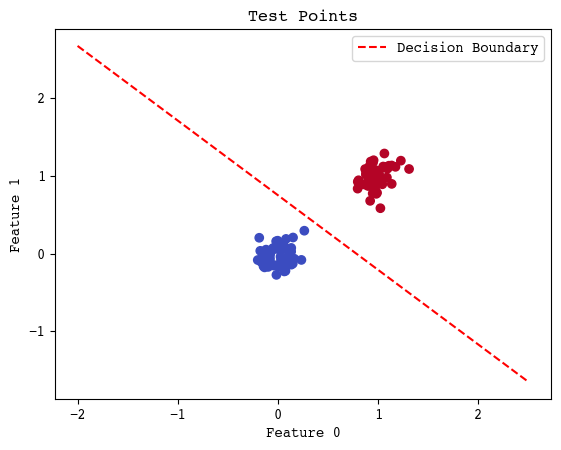

[tensor(0.6644), tensor(0.6233), tensor(0.5773), tensor(0.5348), tensor(0.4970), tensor(0.4638), tensor(0.4344), tensor(0.4082), tensor(0.3847), tensor(0.3636), tensor(0.3445), tensor(0.3271), tensor(0.3112), tensor(0.2967), tensor(0.2833), tensor(0.2710), tensor(0.2597), tensor(0.2492), tensor(0.2395), tensor(0.2304), tensor(0.2220), tensor(0.2142), tensor(0.2068), tensor(0.1999), tensor(0.1935), tensor(0.1874), tensor(0.1817), tensor(0.1763), tensor(0.1712), tensor(0.1664), tensor(0.1619), tensor(0.1576), tensor(0.1535), tensor(0.1496), tensor(0.1459), tensor(0.1424), tensor(0.1390), tensor(0.1358), tensor(0.1327), tensor(0.1298), tensor(0.1270), tensor(0.1243), tensor(0.1217), tensor(0.1192), tensor(0.1169), tensor(0.1146), tensor(0.1124), tensor(0.1103), tensor(0.1083), tensor(0.1063), tensor(0.1044), tensor(0.1026), tensor(0.1008), tensor(0.0991), tensor(0.0975), tensor(0.0959), tensor(0.0944), tensor(0.0929), tensor(0.0914), tensor(0.0900), tensor(0.0887), tensor(0.0874), tensor(

Text(0.5, 1.0, 'Model Loss Over Iterations')

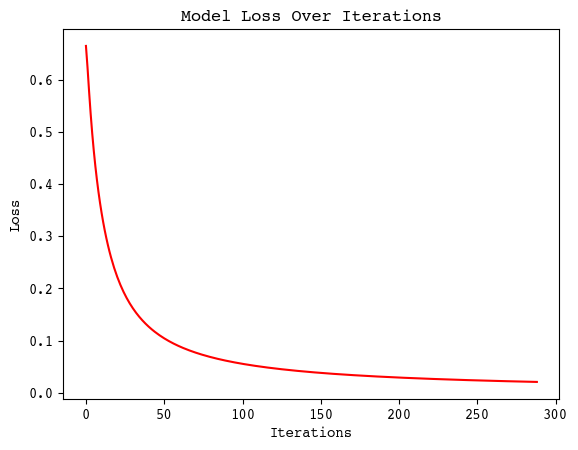

In [9]:
#Define parameters, testing data, and initialize model
n = 100
p = 2
gamma = .12
X, y = Utility.classification_data(n, gamma, p)
LR = LogisticRegression()
LR.w = None
alpha = .5
beta = .25
epsilon = .01
#Train the model and extract the weights
res = Utility.train_logistic(X, y, alpha, beta, epsilon, LR)
w = LR.w
#plotting decision boundary
plt.scatter(X[:,0], X[:, 1], c = y, cmap = "coolwarm")
Utility.draw_line(w, -2, 2.5, plt, color = "red", linestyle = "dashed", label = "Decision Boundary")
plt.legend()
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")
plt.title("Test Points")
plt.show()
#plotting loss over iterations
[num_iters, loss] = res
print(loss)
i = torch.arange(0, num_iters)
print(loss) 
plt.plot(i, loss, color = "red")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Model Loss Over Iterations")

The good news is that our model is able to cleanly partition the two points and loss is decreasing over time. This indicates that our model is working!

### Benefits of Momentum

For small data sets, rates of convergence it not a big issues. However, for $n$ and $p$ large (think billions) we would like to things to go fast. This is where the momentum term comes into play. Intuitvely, if two consecutive points both have large negative gradients, we likely need to increase our step size. If the converse is true, we ought to reduce it.

Again, we'll let $n = 100$. To make things harder, we will set $p = 10$ and increase to $\gamma = .25$. We will also increase the $\epsilon$-tolerence to $.1$ for easier visualization. For Vanilla Gradient Descent, we again take $\beta = 0$ and change it to $\beta = .75$ for Gradient Descent with Momentum.

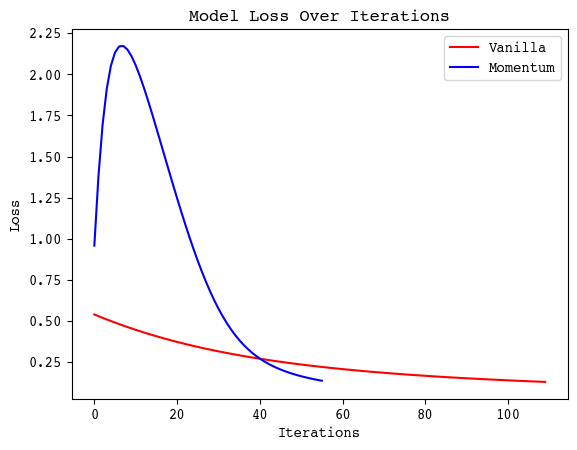

In [12]:
#Define parameters and Testing Data
n = 100
p = 10
gamma = .25
alpha = .1
beta = 0
epsilon = .1
X, y = Utility.classification_data(n, gamma, p)
#Initialize Model and train Vanilla Gradient Descent
LR = LogisticRegression()
res = Utility.train_logistic(X, y, alpha, beta, epsilon, LR)
#Reset and Train Gradient Descent with Momentum
LR.w = None
beta = .75 #increase beta term
res_momentum = Utility.train_logistic(X, y, alpha, beta, epsilon, LR)
#plotting
[num_iters, loss] = res
[num_iters_momentum, loss_momentum] = res_momentum
iters = torch.arange(0, num_iters)
iters_momentum = torch.arange(0, num_iters_momentum)
plt.plot(iters, loss, color = "red", label = "Vanilla")
plt.plot(iters_momentum, loss_momentum, color = "Blue", label = "Momentum")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Model Loss Over Iterations")
plt.legend()

This is a great demonstration. Not only does Momentum Gradient Descent converge in 40 iterations faster than Vanilla Gradient Descent, but we also see how the momentum term causes the algorithm to overestimate weights before converging to a more optimal solution! 

### Overfitting

Finally, we test overfitting. In machine learning, overfitting occurs when we choose features the produce a high degree of accuracy in the training data, but don't generalize to testing data well. In our experiment, we can model this by letting the number of features be greater than the number of observation. We take $n = 15$ and $p = 30$ to improve the speed at which we can find a high accuracy solution. Here, we generate some test set which is unknown to the model. Then, we find a training set that enables the model to achieve 100% accuracy. Finally we extract the weights from the trained model, and apply them to test set to how well they generialize:

Training Accuracy: 1.0
Testing Accuracy: 0.8666666666666667


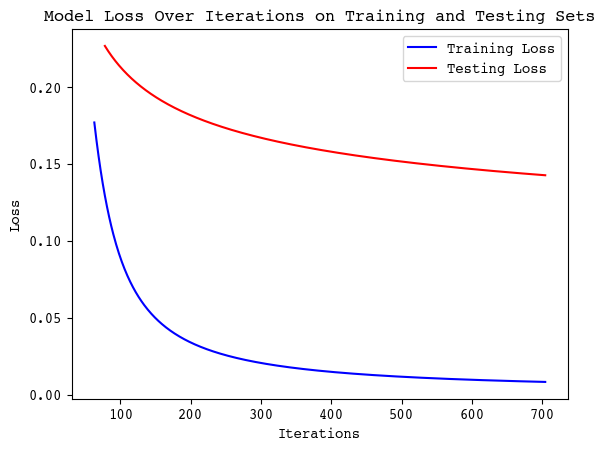

In [149]:
#Define parameters, instantiate model
beta = .25
n = 15
p = 30
gamma = .5
alpha = .1
beta = .1
epsilon = .01
LR = LogisticRegression()
#generate training and testing data
X_test, y_test = Utility.classification_data(n, gamma, p)
#Generate new training sets until 100% accuracy is achieved
while True:

    X_train, y_train = Utility.classification_data(n, gamma, p)
    res = Utility.train_logistic_with_test(X_train, y_train, X_test, y_test, alpha, beta, epsilon, LR)
    pred = LR.predict(X_train)
    matching_count = torch.sum(y_train == pred).item()
    percentage_match = (matching_count / len(pred))

    if (percentage_match == 1):
        break
    else:
        LR.w = None
#Printing Accuracy Results
print("Training Accuracy: " + str(percentage_match))
pred = (torch.matmul(X_test, LR.w) > 0).int()
matching_count = torch.sum(y_test == pred).item()
percentage_match = (matching_count / len(pred))
print("Testing Accuracy: " + str(percentage_match))
#Loss over Iterations
[num_iters, train_loss, test_loss] = res
iters = torch.arange(0, num_iters)
plt.plot(iters, train_loss, color = "blue", label = "Training Loss")
plt.plot(iters, test_loss, color = "red", label = "Testing Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Model Loss Over Iterations on Training and Testing Sets")
plt.legend()

Unsurprisingly, although our model has a training accuracy of 100%, the testing set only had a accuracy of 86%. Moreover, we see that as the model trains in the training set, it it does not reduce loss as dramatically on the testing set. 

## Conclusion

![Gradient Descent in $\mathbb{R}^2$](media/descent.jpg)

Today we gave a high level overview of some of the mathematics the inform gradient descent. We used these ideas to implement gradient descent with Logistic Loss in PyTorch, discussing some of the components critical to the algorithm. Finally, we performed prooft-of-concept tests to demonstrate the mechanics behind regression models in the real world. Besides an intuitive understanding of gradient descent and loss minimization, there are two key observations that the reader should walk away with. First, gradient descent with momentum can speed up convergence, but may come at the cost of precision. As we saw in the second experiment, although Momentum Gradient Descent converged quicker, it first had to diverge. This can mean that It may "skip" or "bounce" over solutions more often than Vanilla Gradient Descent. Second, is that using too many features comes at the cost of algorithm speed and generializability. As we saw in the third experiment, although a large number of features may produce a high degree of accuracy on the training set, that predictive power does not generialize well. This truely is an instance of quality over quantity. 